# Part 1: Neural Networks Basics

## Introduction

In this part, you'll implement a simple neural network for EMNIST character recognition. This will help you understand the fundamentals of neural networks, including dense layers, activation functions, and dropout.

## Learning Objectives

- Load and preprocess EMNIST dataset
- Implement a simple neural network with dense layers
- Train and evaluate the model
- Save model and metrics in the correct format

## Setup and Installation

In [4]:
# Install required packages
#%pip install -r requirements.txt

# Import necessary libraries
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Set random seeds for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

# Configure matplotlib for better visualization
#plt.style.use('seaborn')
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

# Create directories
os.makedirs('models', exist_ok=True)
os.makedirs('results/part_1', exist_ok=True)
os.makedirs('logs', exist_ok=True)

## 1. Data Loading and Preprocessing

Note: you may need to restart the kernel to use updated packages.


2025-05-27 16:58:19.289447: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-05-27 16:58:23.744284: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Training data shape: (71040, 28, 28)
Test data shape: (17760, 28, 28)
Number of classes: 26


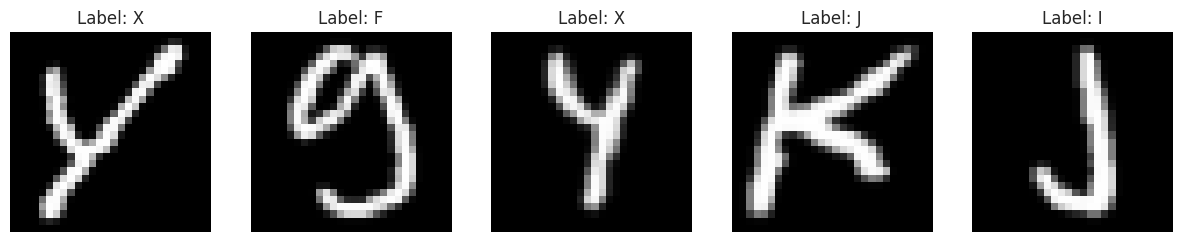

In [11]:
%pip install tensorflow-datasets

import tensorflow_datasets as tfds
import numpy as np
import tensorflow as tf

# Load EMNIST dataset
datasets, info = tfds.load(
    'emnist/letters',
    split=['train[:80%]', 'train[80%:]'],
    as_supervised=True,
    with_info=True
)

train_ds, test_ds = datasets

# Convert to NumPy arrays
x_train, y_train = zip(*[(img.numpy().squeeze(), lbl.numpy() - 1) for img, lbl in train_ds])
x_test, y_test = zip(*[(img.numpy().squeeze(), lbl.numpy() - 1) for img, lbl in test_ds])

x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)

# Print dataset information
print(f"Training data shape: {x_train.shape}")
print(f"Test data shape: {x_test.shape}")
print(f"Number of classes: {len(np.unique(y_train))}")

# Plot sample images
plt.figure(figsize=(15, 5))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(x_train[i].T, cmap='gray')
    plt.title(f'Label: {chr(y_train[i] + 64)}')
    plt.axis('off')
plt.show()

In [12]:
# Preprocess data
# Normalize pixel values
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Reshape for dense layers
x_train = x_train.reshape(-1, 28 * 28)
x_test = x_test.reshape(-1, 28 * 28)

# Convert labels to one-hot encoding
y_train = tf.keras.utils.to_categorical(y_train - 1, num_classes=26)
y_test = tf.keras.utils.to_categorical(y_test - 1, num_classes=26)

# Split training data into train and validation
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(
    x_train, y_train, test_size=0.2, random_state=42
)

print(f"Preprocessed training data shape: {x_train.shape}")
print(f"Preprocessed validation data shape: {x_val.shape}")
print(f"Preprocessed test data shape: {x_test.shape}")

Preprocessed training data shape: (56832, 784)
Preprocessed validation data shape: (14208, 784)
Preprocessed test data shape: (17760, 784)


## 2. Model Implementation

In [14]:
from tensorflow.keras import layers

# Create simple neural network
def create_simple_nn(input_shape, num_classes):
    """
    Create a simple neural network for EMNIST classification.
    
    Requirements:
    - Must use at least 2 dense layers
    - Must include dropout layers
    - Must use categorical crossentropy loss
    
    Goals:
    - Achieve > 80% accuracy on test set
    - Minimize overfitting using dropout
    - Train efficiently with appropriate batch size
    
    Args:
        input_shape: Shape of input data (should be (784,) for flattened 28x28 images)
        num_classes: Number of output classes (26 for letters)
    
    Returns:
        Compiled Keras model
    """
    model = tf.keras.Sequential([
        layers.InputLayer(shape=input_shape),

        # 1st dense layer
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.3),

        # 2nd dense layer
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),

        # Output layer
        layers.Dense(num_classes, activation='softmax')
    ])
    
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# Create and compile model
model = create_simple_nn(input_shape=(784,), num_classes=26)
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │       200,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 26)             │         3,354 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 237,210 (926.60 KB)

 Trainable params: 237,210 (926.60 KB)

 Non-trainable params: 0 (0.00 B)

## 3. Training and Evaluation

Epoch 1/20


2025-05-27 17:04:49.066106: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 178225152 exceeds 10% of free system memory.


1776/1776 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5372 - loss: 1.5594

2025-05-27 17:04:55.336209: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 44556288 exceeds 10% of free system memory.


1776/1776 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.5373 - loss: 1.5591 - val_accuracy: 0.8216 - val_loss: 0.5769 - learning_rate: 0.0010
Epoch 2/20
1776/1776 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.7769 - loss: 0.7185 - val_accuracy: 0.8577 - val_loss: 0.4513 - learning_rate: 0.0010
Epoch 3/20
1776/1776 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8125 - loss: 0.5983 - val_accuracy: 0.8644 - val_loss: 0.4134 - learning_rate: 0.0010
Epoch 4/20
1776/1776 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8266 - loss: 0.5386 - val_accuracy: 0.8758 - val_loss: 0.3776 - learning_rate: 0.0010
Epoch 5/20
1776/1776 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8410 - loss: 0.4908 - val_accuracy: 0.8846 - val_loss: 0.3603 - learning_rate: 0.0010
Epoch 6/20
1776/1776 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8492 - loss: 0.4689 - val_accuracy: 0.8865 - val_loss: 0.3477 - learning_rate: 0.0010
Epoch 7/20
1776/1776 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8557 - loss: 0.4441

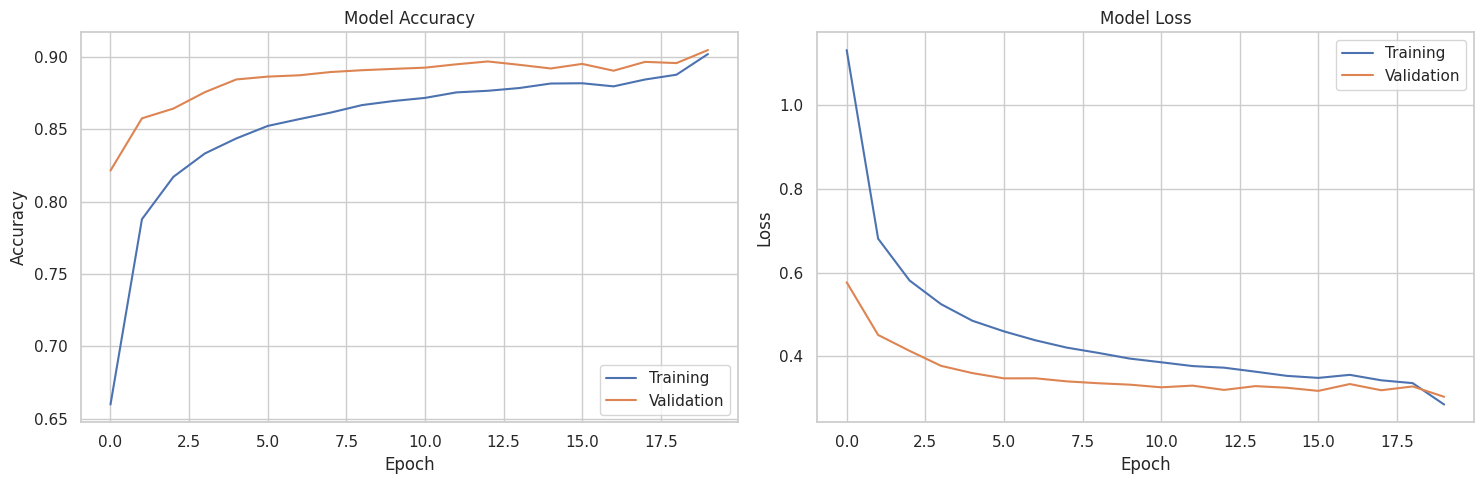

In [15]:
# Define callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=3
    ),
    tf.keras.callbacks.ModelCheckpoint(
        'models/emnist_classifier.keras',
        save_best_only=True
    )
]

# Train model
history = model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=20,
    batch_size=32,
    callbacks=callbacks
)

# Plot training curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot accuracy
ax1.plot(history.history['accuracy'], label='Training')
ax1.plot(history.history['val_accuracy'], label='Validation')
ax1.set_title('Model Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()

# Plot loss
ax2.plot(history.history['loss'], label='Training')
ax2.plot(history.history['val_loss'], label='Validation')
ax2.set_title('Model Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()

plt.tight_layout()
plt.show()

555/555 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9063 - loss: 0.3048
Test accuracy: 0.9058
555/555 ━━━━━━━━━━━━━━━━━━━━ 1s 976us/step


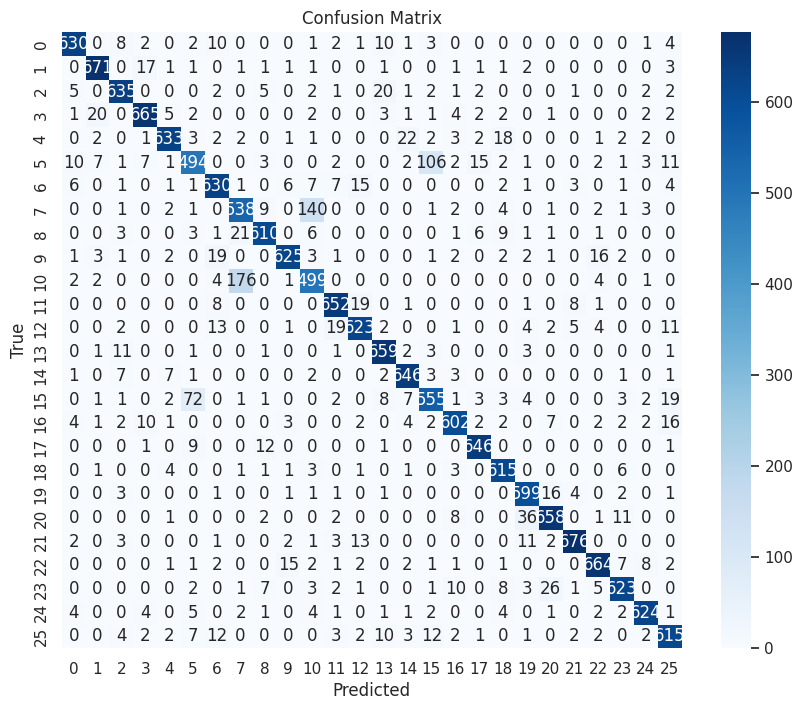

In [19]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

# Evaluate model
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print(f"Test accuracy: {test_accuracy:.4f}")

# Get predictions
predictions = model.predict(x_test)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(y_test, axis=1)

# Calculate Metrics
precision = precision_score(true_labels, predicted_labels, average='macro')
recall = recall_score(true_labels, predicted_labels, average='macro')
f1 = f1_score(true_labels, predicted_labels, average='macro')
cm = confusion_matrix(true_labels, predicted_labels)

# Calculate confusion matrix
cm = tf.math.confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Save metrics
metrics = {
    'model': 'emnist_classifier',
    'accuracy': float(test_accuracy),
    'precision': float(precision),
    'recall': float(recall),
    'f1_score': float(f1),
    'confusion_matrix': cm.numpy().tolist()
}

# Save to file
with open('results/part_1/emnist_classifier_metrics.txt', 'w') as f:
    f.write(f"model: {metrics['model']}\n")
    f.write(f"accuracy: {metrics['accuracy']}\n")
    f.write(f"precision: {metrics['precision']}\n")
    f.write(f"recall: {metrics['recall']}\n")
    f.write(f"f1_score: {metrics['f1_score']}\n")
    f.write(f"confusion_matrix: {metrics['confusion_matrix']}\n")
    f.write("----\n")

## Progress Checkpoints

1. **Data Loading**:
   - [ ] Successfully load EMNIST dataset
   - [ ] Verify data shapes and ranges
   - [ ] Visualize sample images

2. **Preprocessing**:
   - [ ] Normalize pixel values
   - [ ] Reshape data for dense layers
   - [ ] Convert labels to one-hot encoding

3. **Model Implementation**:
   - [ ] Create model with required layers
   - [ ] Verify architecture requirements
   - [ ] Test model with sample input

4. **Training**:
   - [ ] Train model with callbacks
   - [ ] Monitor training progress
   - [ ] Save best model

5. **Evaluation**:
   - [ ] Calculate performance metrics
   - [ ] Save metrics in correct format
   - [ ] Visualize results

## Common Issues and Solutions

1. **Data Loading Issues**:
   - Problem: EMNIST dataset not found
   - Solution: Check internet connection and TensorFlow installation

2. **Preprocessing Issues**:
   - Problem: Shape mismatch in dense layers
   - Solution: Ensure data is properly reshaped to (n_samples, 784)
   - Problem: Label encoding errors
   - Solution: Verify label range and one-hot encoding

3. **Model Issues**:
   - Problem: Training instability
   - Solution: Add batch normalization, reduce learning rate
   - Problem: Overfitting
   - Solution: Increase dropout, use data augmentation

4. **Evaluation Issues**:
   - Problem: Metrics format incorrect
   - Solution: Follow the exact format specified
   - Problem: Performance below threshold
   - Solution: Adjust architecture, hyperparameters